# Età padre - figli

In [1]:
regioni = ["Valle d\'Aosta","Piemonte","Lombardia"]
filter_df_rules = [("REGMf", "==", regioni)]

# In the mother-child rule, ind1 is the child and ind2 is the father.
parent_sex = 1 # Father
male_sex = ("SESSO", "==", parent_sex)
father_child_rules = [
    {"name": "RELPAR_6",
    "ind1": [("RELPAR", "==", 6)],            # Child
    "ind2": [("RELPAR", "==", 1), male_sex]}, # Father
    {"name": "RELPAR_7_1",
    "ind1": [("RELPAR", "==", 7)],            # Child
    "ind2": [("RELPAR", "==", 1), male_sex]}, # Father
    {"name": "RELPAR_7_2",
    "ind1": [("RELPAR", "==", 7)],            # Child
    "ind2": [("RELPAR", "==", 2), male_sex]}, # Father
    {"name": "RELPAR_4_1",
    "ind1": [("RELPAR", "==", 1)],            # Child
    "ind2": [("RELPAR", "==", 4), male_sex]}, # Father
    {"name": "RELPAR_5_2",
    "ind1": [("RELPAR", "==", 2)],            # Child
    "ind2": [("RELPAR", "==", 5), male_sex]}, # Father
    {"name": "RELPAR_5_2",
    "ind1": [("RELPAR", "==", 3)],            # Child
    "ind2": [("RELPAR", "==", 5), male_sex]}, # Father
    {"name": "RELPAR_5_2",
    "ind1": [("RELPAR", "==", 3)],            # Child
    "ind2": [("RELPAR", "==", 5), male_sex]}, # Father
    {"name": "Fallback_RELPAR_6_2",
    "ind1": [("RELPAR", "==", 6)],            # Child
    "ind2": [("RELPAR", "==", 2), male_sex]}, # Father
    {"name": "Fallback_RELPAR_6_3",
    "ind1": [("RELPAR", "==", 6)],            # Child
    "ind2": [("RELPAR", "==", 3), male_sex]}, # Father
]

In [ ]:
from microdata_extractor import ISTATMicrodataExtractor
avq = ISTATMicrodataExtractor("AVQ",get_polars=True)
avq.load_data("AVQ_2023_IT")

In [6]:
import polars as pl

attrs_pair = ["ETAMi"] # These are the attributes that will be returned.
father_child_pairs_df = avq.pair_family_members(
        father_child_rules, 
        attrs=attrs_pair, 
        # filter_df_rules=filter_df_rules
    )

# Discard rows where the father's age (ETAMi_ind2) is lower or equal to the child's age (ETAMi_ind1)
father_child_pairs_df = father_child_pairs_df.filter(
    ~((pl.col("ETAMi_ind2") <= pl.col("ETAMi_ind1")) &
        (pl.col("ETAMi_ind2") < 15) # ETAMi=15 -> "older than 75 years old" (there can be father and child both older than 75))
    )
)

In [ ]:
# joint is the dataframe with the joint distribution.
joint = avq.joint_distribution(
            attrs=["ETAMi_ind1", "ETAMi_ind2"],
            df=father_child_pairs_df,
            normalise=True,
        )

# Rename the columns for clarity
joint = joint.rename(
    {
        "ETAMi_ind1": "child_age",
        "ETAMi_ind2": "father_age"
    }
)
print(joint)

shape: (63, 4)
┌───────────┬────────────┬───────┬──────────┐
│ child_age ┆ father_age ┆ count ┆ prob     │
│ ---       ┆ ---        ┆ ---   ┆ ---      │
│ i64       ┆ i64        ┆ u32   ┆ f64      │
╞═══════════╪════════════╪═══════╪══════════╡
│ 3         ┆ 11         ┆ 667   ┆ 0.069076 │
│ 3         ┆ 10         ┆ 639   ┆ 0.066176 │
│ 4         ┆ 11         ┆ 571   ┆ 0.059134 │
│ 9         ┆ 13         ┆ 559   ┆ 0.057891 │
│ 8         ┆ 11         ┆ 539   ┆ 0.05582  │
│ …         ┆ …          ┆ …     ┆ …        │
│ 3         ┆ 15         ┆ 1     ┆ 0.000104 │
│ 11        ┆ 13         ┆ 1     ┆ 0.000104 │
│ 1         ┆ 13         ┆ 1     ┆ 0.000104 │
│ 10        ┆ 11         ┆ 1     ┆ 0.000104 │
│ 7         ┆ 15         ┆ 1     ┆ 0.000104 │
└───────────┴────────────┴───────┴──────────┘


In [8]:
joint_prob_heatmap = (
    joint
    .pivot(
        values="prob",
        index="child_age", # Rows
        on="father_age",        # Columns
        aggregate_function="first"  # assuming each pair is unique
    )
    .fill_null(0) # Fill NaN with 0
    .with_columns(pl.col("child_age").cast(pl.Int32))
    .sort("child_age", descending=True)  # Sort child_age descending (top to bottom)
)


# Sort columns by father_age ascending (left to right)
father_age_cols = sorted(
    [int(col) for col in joint_prob_heatmap.columns if col != "child_age"]
)
father_age_cols_str = [str(col) for col in father_age_cols]

joint_prob_heatmap = joint_prob_heatmap.select(["child_age"] + father_age_cols_str)
joint_prob_heatmap

child_age,8,9,10,11,12,13,14,15
i32,f64,f64,f64,f64,f64,f64,f64,f64
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000932
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002071
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006835
11,0.0,0.0,0.0,0.0,0.0,0.000104,0.006214,0.027341
10,0.0,0.0,0.0,0.000104,0.001036,0.00756,0.033761,0.015327
…,…,…,…,…,…,…,…,…
5,0.0,0.000311,0.010874,0.040182,0.010356,0.002175,0.000518,0.0
4,0.0,0.000414,0.023923,0.059134,0.011288,0.0029,0.000725,0.0
3,0.0,0.006421,0.066176,0.069076,0.00611,0.001657,0.000621,0.000104


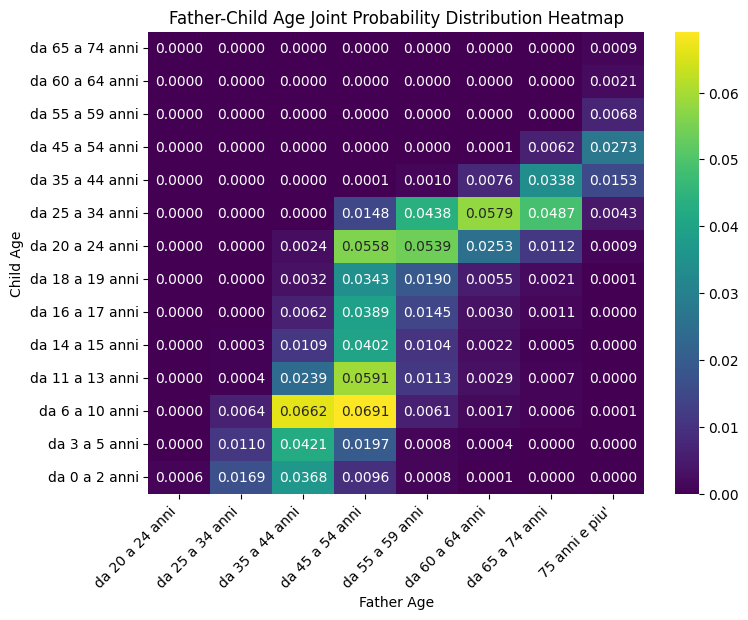

In [9]:
# Plot the results
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    joint_prob_heatmap[:,1:],
    cmap="viridis",
    annot=True,
    fmt=".4f"
)

# Set x and y labels
age_labels = avq.get_attribute_metadata("ETAMi", print_output=False)
xticks = joint_prob_heatmap.columns[1:]
yticks = joint_prob_heatmap.select(pl.col("child_age")).to_series().unique().sort(descending=True)
ax.set_xticks([el+0.5 for el in range(len(xticks))])
ax.set_xticklabels([age_labels.get(int(val)) for val in xticks], rotation=45, ha='right')

ax.set_yticks([el+0.5 for el in range(len(yticks))])
ax.set_yticklabels([age_labels.get(val) for val in yticks], rotation=0, ha='right')

plt.title("Father-Child Age Joint Probability Distribution Heatmap")
plt.xlabel("Father Age")
plt.ylabel("Child Age")
plt.show()